In [1]:
# Here we import all libraries
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
import torch
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import deque 
import sys
env = gym.make("CartPole-v0")

C:\Users\thoma\anaconda3\envs\torch_1\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\thoma\anaconda3\envs\torch_1\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\thoma\anaconda3\envs\torch_1\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
#Hyperparameters
episodes = 20000*5
eps = 1.0
learning_rate = 0.001
tot_rewards = []
tot_loss = []
decay_val = 0.0001
mem_size = 1000000
batch_size = 300
gamma = 0.99
update_target = 100
max_steps = 200

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(state_size, 300),
            nn.ReLU(),
            nn.Linear(300, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [4]:
model = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
target = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

opt = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
replay_buffer = deque(maxlen=mem_size)

In [5]:
#Testing code

# state = torch.tensor(env.reset(), dtype=torch.float32)
# print("state = ", state)
# out = model(state)
# print("out = ", out)

In [6]:
def compute_td_loss(batch_size):
    state, next_state, reward, done, action = zip(*random.sample(replay_buffer, batch_size))
    state = torch.stack(list(state), dim=0).reshape(batch_size, -1)

    next_state = torch.from_numpy(np.array(next_state).reshape(batch_size, -1)).type(torch.float32)
    
    reward = torch.from_numpy(np.array(reward))
    done = torch.from_numpy(np.array(done)).long()
    action = torch.from_numpy(np.array(action)).type(torch.int64)
    
    q_values = model(state)
    next_q_values = target(next_state)

    q_vals = q_values.gather(dim=-1, index=action.reshape(-1,1))
    max_next_q_values = torch.max(next_q_values,-1)[0].detach()

    loss = ((reward + gamma*max_next_q_values*(1-done) - q_vals.squeeze())**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss
    

Episode =  0  Epsilon =  1.0


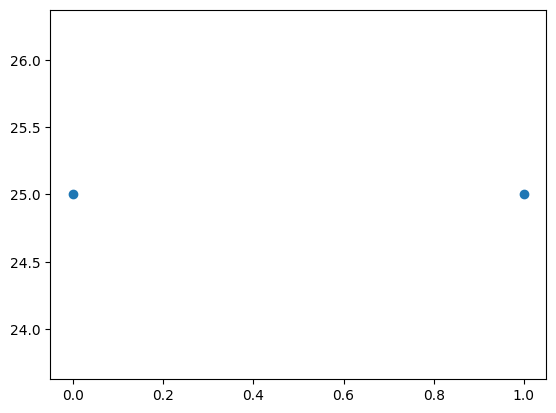

Episode =  1  Epsilon =  0.9975032470770467
Episode =  2  Epsilon =  0.9964066515722192
Episode =  3  Epsilon =  0.9947142838016884
Episode =  4  Epsilon =  0.9912390427867775
Episode =  5  Epsilon =  0.989852348373013
Episode =  6  Epsilon =  0.9866900413605216
Episode =  7  Epsilon =  0.9854082417459263
Episode =  8  Epsilon =  0.9841281073049752
Episode =  9  Epsilon =  0.9825548399448463
Episode =  10  Epsilon =  0.9805917921178561
Episode =  11  Epsilon =  0.9779478973357154
Episode =  12  Epsilon =  0.9765797965773194
Episode =  13  Epsilon =  0.9746286862986691
Episode =  14  Epsilon =  0.9732652289524114
Episode =  15  Epsilon =  0.9712236184916713
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  16  Epsilon =  0.9693801376503953
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  17  Epsil

torch.Size([300])
torch.Size([300])
Episode =  61  Epsilon =  0.8576215844801943
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  62  Epsilon =  0.8559081409965832
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  63  Epsilon =  0.8542835406164255
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  64  Epsilon =  0.8535150697165496
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  65  Epsilon =  0.8509584891225299
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  66  Epsilon =  0.8497680402678377
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  67  Epsilon =  0.8474768755795817
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
t

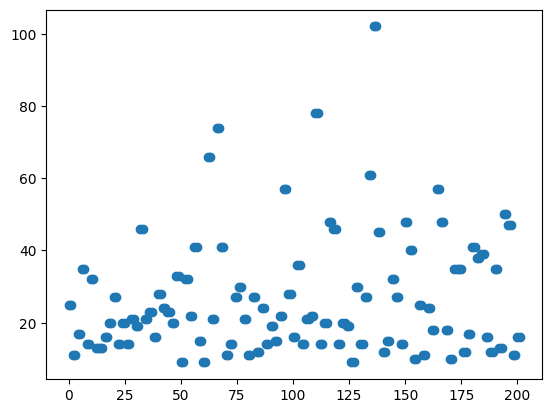

Episode =  101  Epsilon =  0.7642299481122639
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  102  Epsilon =  0.7611031759238602
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  103  Epsilon =  0.760114434052886
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  104  Epsilon =  0.7548879578552493
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
torch.Size([300])
Episode =  105  Epsilon =  0.7523258249969728
torch.Size([300

KeyboardInterrupt: 

In [7]:
for i in range(episodes):
    print("Episode = ", i, " Epsilon = ", eps)
    state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0)

    done = False
    steps = 0
    eps_rew = 0 
    eps_loss = 0
    while not done and steps<max_steps:
        if np.random.uniform(0,1)<eps:
            action = env.action_space.sample()
        else:
#             action = env.action_space.sample()
            action = np.argmax(model(state).detach().numpy())
                

        next_state, reward, done, info = env.step(action)
        replay_buffer.append((state, next_state, reward, done, action))
        if len(replay_buffer)>batch_size and steps%4==0:
            loss = compute_td_loss(batch_size)
            eps_loss += loss.detach().numpy()
        eps = eps/(1 + decay_val)
        eps_rew += reward 
        
        if steps%50==0:
            target.load_state_dict(model.state_dict())
        
        if done:
            tot_rewards.append(eps_rew)
            break
        
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        steps += 1
    tot_rewards.append(eps_rew)
    tot_loss.append(eps_loss)
    
    if(i%100)==0:
        plt.scatter(np.arange(len(tot_rewards)), tot_rewards)
        plt.show()

In [ ]:
plt.plot(tot_loss)

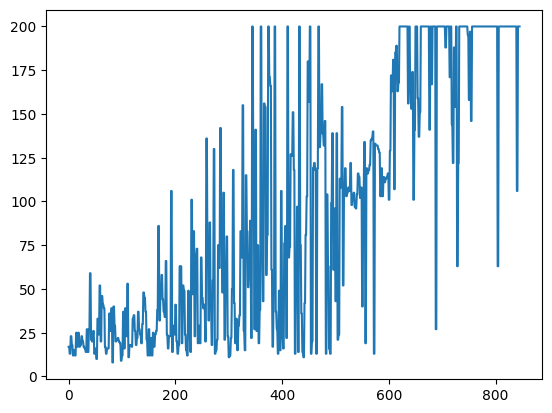

In [9]:
#Plot
plt.plot(tot_rewards)

In [152]:
#Render the final environment
state, info = env.reset(seed=42, return_info=True)
import time
for i in range(1000):
    
    env.render()
    
    state = torch.tensor(state, dtype=torch.float32)
    action = np.argmax(model(state).detach().numpy())
    state, reward, done, info = env.step(action)

    if done:
        state, info = env.reset(return_info=True)
env.close()
